In [73]:
library(nanoparquet)
library(showtext)
library(tidyverse)

options(
  lubridate.week.start = 1,
  readr.show_col_types = FALSE
)

font_add(
  family = "Roboto Condensed",
  regular = "RobotoCondensed-Regular.ttf",
  bold = "RobotoCondensed-Bold.ttf"
)
showtext_auto()

theme_set(
  hrbrthemes::theme_ipsum_rc(
    axis_title_size = 12,
    base_size = 12,
    grid = "XY"
  )
)

colour_solar <- "#f2b130"
colour_solar_dark <- "#be9e5c"
colours_solar5 <- c("#ead2a1", "#f0c36a", "#91723a", "#b98d36", "#f1b63f")
colour_wind <- "dodgerblue"
colours_wind5 <- c("#5989bc", "#d2e1f1", "#78ace4", "#49a0fc", "#496988")

rolling_means <- function(.data, .cols, k, .by = NULL) {
  .data |>
    group_by({{ .by }}) |>
    mutate(
      across(
        {{ .cols }},
        ~ zoo::rollmean(.x, k = k, na.pad = TRUE)
      )
    ) |>
    ungroup() |>
    tidyr::drop_na({{ .cols }})
}

month.names <- c("leden", "únor", "březen", "duben", "květen", "červen", "červenec", "srpen", "září", "říjen", "listopad", "prosinec")
month.len <- c(31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)


# Načítání dat


**Simulovaná výroba OZE z PECD.** Zde načítáme simulovanou výrobu z větru a slunce z datasetu PECD (*Pan-European Climate Database*) pro Česko a celou Evropu. Tento dataset se připravuje v sousedním notebooku `spolehlivost-oze-prep.ipynb`.


In [74]:
df_cz_daily_solar <- load_data_file("eraa2023-ty2025-daily-solar-cz.parquet") |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    SolarCf = cf
  )

df_cz_daily_wind <- load_data_file("eraa2023-ty2025-daily-wind-cz.parquet") |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    WindCf = cf
  )

df_europe_daily_solar <- load_data_file("eraa2023-ty2025-daily-solar-europe.parquet") |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    SolarCf = cf
  )

df_europe_daily_wind <- load_data_file("eraa2023-ty2025-daily-wind-europe.parquet") |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    WindCf = cf
  )

num_years <- df_cz_daily_solar$Year |> unique() |> length()


# Sezónní proměnlivost


## Roční výroba


Podkladová data pro beeswarm ročních výrob:


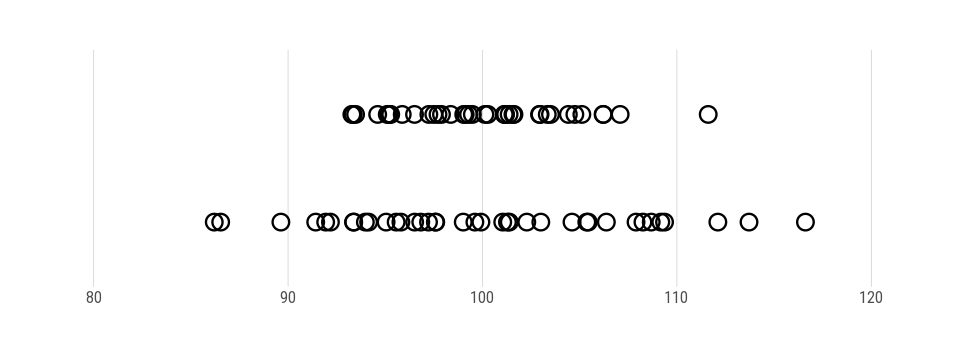

In [ ]:
options(repr.plot.height = 3, repr.plot.width = 8)

df_cz_solar_annual <- df_cz_daily_solar |>
  summarise(SolarProd = sum(SolarCf), .by = c(Year)) |>
  mutate(SolarProdRelative = SolarProd / mean(SolarProd) * 100)

df_cz_wind_annual <- df_cz_daily_wind |>
  summarise(WindProd = sum(WindCf), .by = c(Year)) |>
  mutate(WindProdRelative = WindProd / mean(WindProd) * 100)

rbind(
  select(df_cz_solar_annual, Prod = 3) |> mutate(Source = "Solar"),
  select(df_cz_wind_annual, Prod = 3) |> mutate(Source = "Wind")
) |>
  ggplot(aes(Prod, fct_rev(Source))) +
  geom_point(shape = 1, size = 4, stroke = 1) +
  xlim(80, 120) +
  theme(
    axis.text.y = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major.y = element_blank()
  )


Základní statistická charakteristika relativních ročních výrob ze slunce a větru:


In [76]:
df_cz_solar_annual$SolarProdRelative |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  93.28   96.69   99.80  100.00  102.95  111.61 

In [77]:
df_cz_wind_annual$WindProdRelative |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  86.20   94.37   99.31  100.00  105.42  116.61 

## Měsíční výroba


In [78]:
df_cz_solar_monthly <- df_cz_daily_solar |>
  summarise(SolarProd = 24 * sum(SolarCf), .by = c(Year, Month)) |>
  mutate(SolarProdRelative = SolarProd / mean(SolarProd))

df_cz_wind_monthly <- df_cz_daily_wind |>
  summarise(WindProd = 24 * sum(WindCf), .by = c(Year, Month)) |>
  mutate(WindProdRelative = WindProd / mean(WindProd))

df_cz_res_monthly <- rbind(
  select(df_cz_solar_monthly, Year, Month, Prod = SolarProd, ProdRelative = SolarProdRelative) |>
    mutate(Source = "Solar"),
  select(df_cz_wind_monthly, Year, Month, Prod = WindProd, ProdRelative = WindProdRelative) |>
    mutate(Source = "Wind")
)


Základní statistická charakteristika relativních měsíčních výrob. Kolik se ze slunce a větru v Česku *spolehlivě* vyrobí v měsíčním součtu – tj. jaká jsou minima ročních výrob?


In [108]:
df_cz_solar_monthly$SolarProdRelative |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2467  0.5733  1.0587  1.0000  1.3848  1.7368 

In [109]:
df_cz_wind_monthly$WindProdRelative |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3936  0.7281  0.9440  1.0000  1.2192  2.3523 

Podkladová data a hnusnografy pro měsíční průměry:


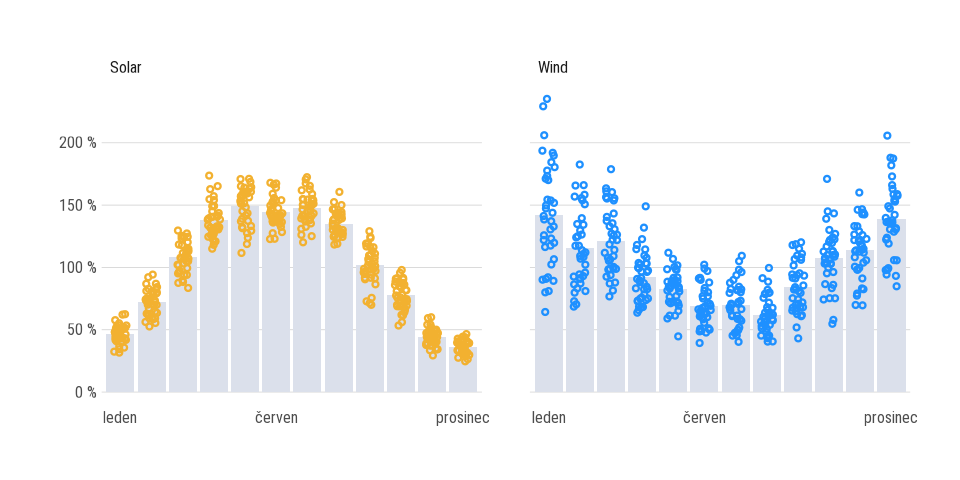

In [81]:
options(repr.plot.height = 4, repr.plot.width = 8)

df_cz_res_monthly |>
  ggplot(aes(ordered(Month), ProdRelative)) +
  stat_summary(
    aes(group = Source),
    fun = mean,
    geom = "col",
    fill = "#dbe0eb"
  ) +
  geom_jitter(
    aes(colour = Source),
    shape = 1,
    size = 1,
    stroke = 1,
    # alpha = .5,
    width = .2
  ) +
  scale_x_discrete(
    breaks = c(1, 6, 12),
    labels = month.names[c(1, 6, 12)]
  ) +
  scale_y_continuous(labels = scales::label_percent(suffix = " %")) +
  scale_colour_manual(
    values = c(colour_solar, colour_wind),
    guide = "none"
  ) +
  expand_limits(y = 0) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major.x = element_blank()
  ) +
  facet_wrap(vars(Source))


Měsiční průměry relativních výrob:


In [80]:
df_cz_res_monthly |>
  summarise(across(ProdRelative, ~ round(mean(.x), 2)), .by = c(Source, Month)) |>
  pivot_wider(names_from = Month, values_from = ProdRelative)


Source,1,2,3,4,5,6,7,8,9,10,11,12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Solar,0.47,0.72,1.08,1.38,1.49,1.44,1.47,1.35,1.02,0.78,0.44,0.36
Wind,1.42,1.16,1.21,0.92,0.83,0.69,0.70,0.62,0.85,1.07,1.14,1.39


Směrodatné odchylky po měsících:


In [110]:
df_cz_res_monthly |>
  summarise(round(sd(ProdRelative), 3), .by = c(Source, Month)) |>
  pivot_wider(names_from = Month, values_from = 3)


Source,1,2,3,4,5,6,7,8,9,10,11,12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Solar,0.072,0.107,0.122,0.136,0.152,0.115,0.124,0.098,0.145,0.112,0.069,0.054
Wind,0.421,0.303,0.264,0.197,0.141,0.157,0.180,0.149,0.202,0.233,0.223,0.289


## Kombinace slunce + vítr


Vizualizace vztahu mezi výrobou ze slunce a z větru v součtu za měsíc:


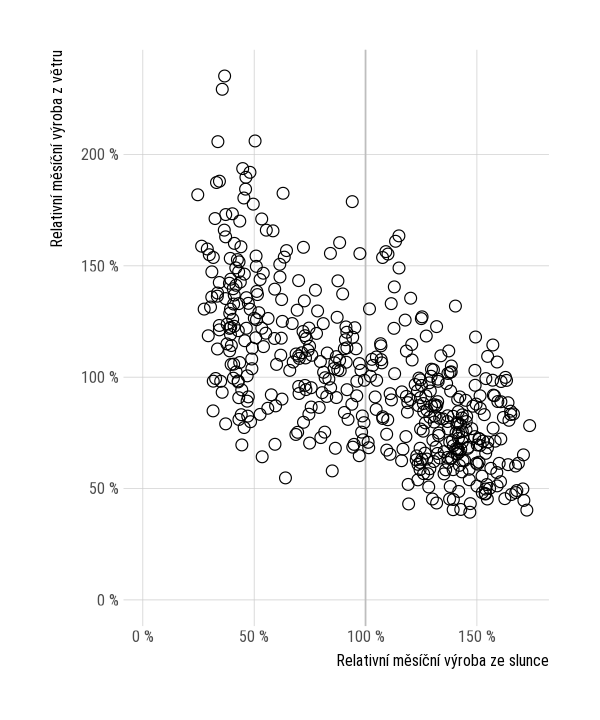

In [124]:
options(repr.plot.height = 6, repr.plot.width = 5)

df_cz_res_monthly |>
  select(!Prod) |>
  pivot_wider(names_from = Source, values_from = ProdRelative) |>
  ggplot(aes(Solar, Wind)) +
  # geom_hline(yintercept = 1, colour = "grey") +
  geom_vline(xintercept = 1, colour = "grey") +
  geom_point(shape = 1, size = 3) +
  scale_x_continuous(
    "Relativní měsíční výroba ze slunce",
    labels = scales::label_percent(suffix = " %")
  ) +
  scale_y_continuous(
    "Relativní měsíční výroba z větru",
    labels = scales::label_percent(suffix = " %")
  ) +
  expand_limits(x = 0, y = 0) +
  coord_fixed()


Graf kombinované měsíční výroby ze slunce a větru při poměru instalovaných výkonů 2 : 3 (slunce : vítr, tj. přibližně 1 : 3 v roční výrobě):


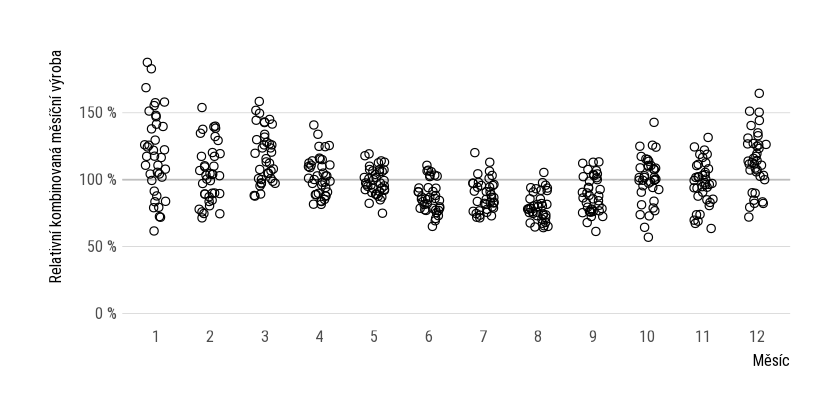

In [134]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

solar_share <- .4

df_cz_res_monthly_combined <- df_cz_res_monthly |>
  select(!ProdRelative) |>
  pivot_wider(names_from = Source, values_from = Prod) |>
  mutate(
    Combined = solar_share * Solar + (1 - solar_share) * Wind
  )

df_cz_res_monthly_combined |>
  ggplot(aes(ordered(Month), Combined / mean(Combined))) +
  geom_hline(yintercept = 1, colour = "grey") +
  geom_jitter(width = .2, shape = 1, size = 2) +
  scale_y_continuous(
    "Relativní kombinovaná měsíční výroba",
    labels = scales::label_percent(suffix = " %")
  ) +
  xlab("Měsíc") +
  expand_limits(y = 0) +
  theme(panel.grid.major.x = element_blank())


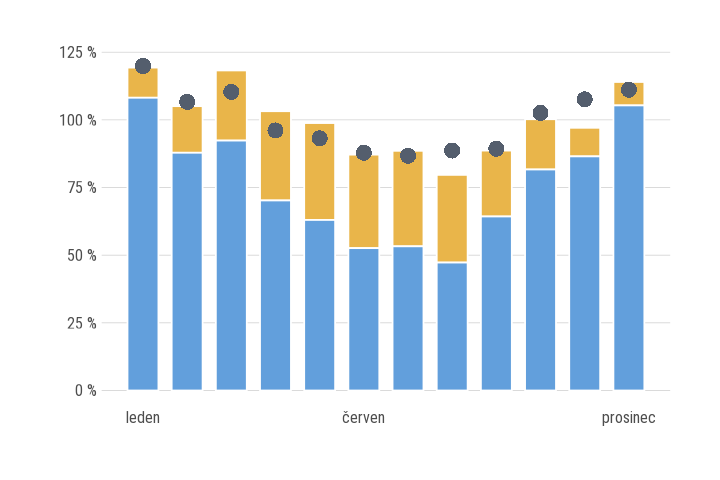

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)

# Měsíční spotřeba vypočítána z PECD pro cílový rok 2030
# (průměr přes všechny roky počasí).
df_monthly_demand <- tribble(
  ~ Month, ~ DemandTWh,
    1,    7.41,
    2,    6.59,
    3,    6.82,
    4,    5.94,
    5,    5.76,
    6,    5.43,
    7,    5.36,
    8,    5.48,
    9,    5.52,
   10,    6.34,
   11,    6.65,
   12,    6.87
)

df_cz_res_monthly_combined |>
  summarise(across(Solar | Wind | Combined, mean), .by = Month) |>
  ggplot(aes(Month, Combined / mean(Combined))) +
  geom_col(
    aes(y = Combined, fill = Source),
    width = .7,
    position = "stack",
    linewidth = .5,
    colour = "white",
    data = ~ .x |>
      transmute(
        Month,
        Solar = solar_share * Solar / mean(Combined),
        Wind = (1 - solar_share) * Wind / mean(Combined),
      ) |>
      pivot_longer(!Month, names_to = "Source", values_to = "Combined")
  ) +
  geom_point(
    aes(y = DemandTWh / mean(DemandTWh)),
    data = df_monthly_demand,
    colour = "#545e6d",
    size = 4.5,
    stroke = 0
  ) +
  scale_x_continuous(
    breaks = c(1, 6, 12),
    labels = month.names[c(1, 6, 12)]
  ) +
  scale_y_continuous(
    # "Relativní měsíční výroba",
    labels = scales::label_percent(suffix = " %")
  ) +
  scale_fill_manual(guide = "none", values = c("#e9b54a", "#629fdc")) +
  expand_limits(y = 0) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major.x = element_blank()
  )


# Denní proměnlivost


## Kombinace slunce + vítr


Frekvence dní podle toho, do jakého kvantilu spadá jejich výroba ze slunce a z větru:


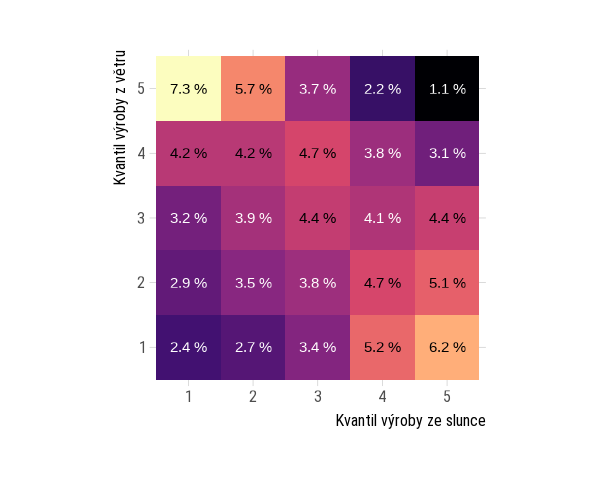

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 5)

num_levels <- 5
cut_breaks <- c(-Inf, seq(1, num_levels - 1) / num_levels,  Inf)

df_cz_daily_both_ranked <- inner_join(
  df_cz_daily_solar,
  df_cz_daily_wind,
  join_by(Date, Year, Month, DayOfYear)
) |>
  mutate(
    SolarQ = (rank(SolarCf) - 1) / (n() - 1),
    WindQ = (rank(WindCf) - 1) / (n() - 1),
    SolarCat = cut(SolarQ, cut_breaks, labels = 1:num_levels),
    WindCat = cut(WindQ, cut_breaks, labels = 1:num_levels)
  )

df_cz_daily_both_ranked |>
  count(SolarCat, WindCat) |>
  ggplot(aes(SolarCat, WindCat)) +
  geom_tile(aes(fill = 100 * n / num_years / 365)) +
  geom_text(
    aes(
      colour = if_else(2 * n < max(n) + min(n), "white", "black"),
      label = paste(round(100 * n / num_years / 365, 1), "%")
    )
  ) +
  scale_colour_identity(guide = "none") +
  scale_fill_viridis_c("%", option = "A", guide = "none") +
  labs(x = "Kvantil výroby ze slunce", y = "Kvantil výroby z větru") +
  coord_fixed()


## Dunkelflaute


*Dunkelflaute* (období, kdy málo fouká i málo svítí slunce) definujeme jako den, kdy kombinovaná výroba ze slunce a větru (v poměru instalovaných výkonů 2 : 3) klesne pod 25 % dlouhodobého průměru (tj. průměru všech dní v datasetu).

Následující graf ukazuje relativní denní výrobu z obou zdrojů. Červená část vymezuje dny, které bychom mohli označit jako *Dunkelflaute*.


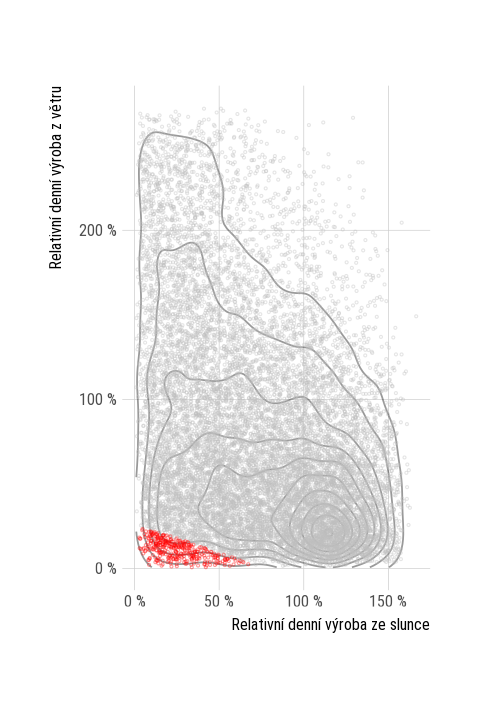

In [211]:
options(repr.plot.height = 6, repr.plot.width = 4)

scarcity_threshold <- .25
solar_share <- .4

df_cz_dunkelflaute <- inner_join(
  df_cz_daily_solar,
  df_cz_daily_wind,
  join_by(Date, Year, Month, DayOfYear)
) |>
  mutate(
    Combined = solar_share * SolarCf + (1 - solar_share) * WindCf,
    Dunkelflaute = Combined / mean(Combined) < scarcity_threshold,
    SolarR = SolarCf / mean(SolarCf[between(Month, 4, 9)]),
    WindR = WindCf / mean(WindCf[Month <= 3 | Month >= 10])
  )

ggplot(df_cz_dunkelflaute, aes(SolarR, WindR)) +
  geom_density_2d(colour = "black", alpha = .4) +
  geom_point(
    aes(colour = Dunkelflaute),
    shape = 1,
    size = .5,
    alpha = .4
  ) +
  scale_x_continuous(
    "Relativní denní výroba ze slunce",
    labels = scales::label_percent(suffix = " %")
  ) +
  scale_y_continuous(
    "Relativní denní výroba z větru",
    labels = scales::label_percent(suffix = " %")
  ) +
  scale_colour_manual(
    values = c("grey", "red"),
    guide = "none"
  ) +
  coord_fixed()


Průměrný počet takových dní v roce:


In [196]:
df_cz_dunkelflaute |>
  summarise(
    dunkelflaute_num_days = sum(Dunkelflaute),
    .by = Year
  ) |>
  pull(2) |>
  summary(dunkelflaute_num_days)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.000   7.000   9.000   9.395  11.000  17.000 

Vizualizace výskytů těchto dní v průběhu různých roků:


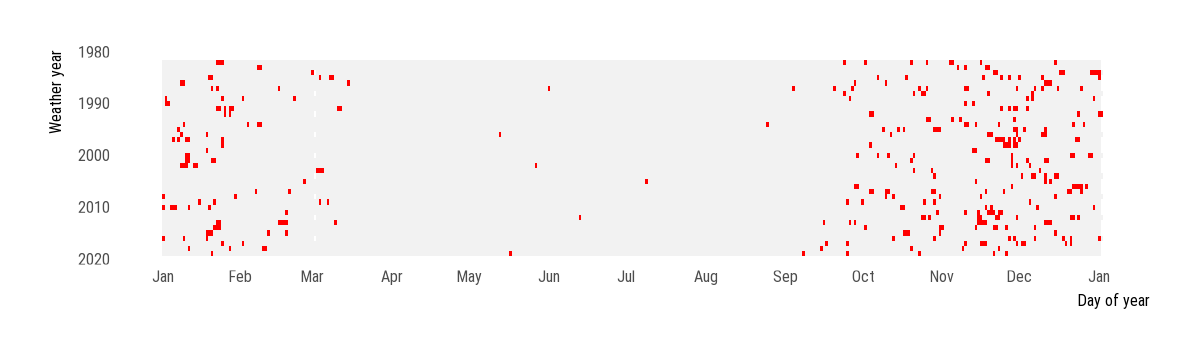

In [197]:
options(repr.plot.height = 3, repr.plot.width = 10)

ggplot(df_cz_dunkelflaute, aes(DayOfYear, Year)) +
  geom_raster(aes(fill = Dunkelflaute)) +
  scale_x_continuous(
    breaks = c(1, cumsum(month.len)),
    labels = c(month.abb, month.abb[1])
  ) +
  scale_y_reverse() +
  scale_fill_manual(
    values = c("grey95", "red"),
    guide = "none"
  ) +
  labs(x = "Day of year", y = "Weather year") +
  theme(
    panel.grid.major = element_blank()
  )


In [ ]:
# df_cz_combined_whole_year <- df_cz_daily_wind |>
#   left_join(df_cz_daily_solar, join_by(Date, Year, Month, DayOfYear)) |>
#   # filter((Month <= 3) | (Month >= 10)) |>
#   mutate(
#     SolarRelative = SolarCf / mean(SolarCf[between(Month, 4, 9)]),
#     WindRelative = WindCf / mean(WindCf[(Month <= 3) | (Month >= 10)]),
#     # Označení roku zimy: Zima roku 2001 označuje přelom roků 200
#     Year = if_else(Month < 6, Year, Year + 1)
#   )

# df_low_combined_intervals <- df_cz_combined_whole_year |>
#   mutate(
#     BelowThreshold = WindRelative < scarcity_threshold & SolarRelative < scarcity_threshold
#   ) |>
#   filter(BelowThreshold) |>
#   group_by(Year) |>
#   mutate(
#     DateDiff = c(1, diff(Date)),
#     Group = cumsum(DateDiff > 1)
#   ) |>
#   group_by(Group, .add = TRUE) |>
#   summarise(
#     StartDate = min(Date),
#     NumDays = n(),
#     .groups = "drop"
#   )

df_cz_dunkelflaute_intervals <- df_cz_dunkelflaute |>
  filter(Dunkelflaute) |>
  group_by(Year) |>
  mutate(
    DateDiff = c(1, diff(Date)),
    Group = cumsum(DateDiff > 1)
  ) |>
  group_by(Group, .add = TRUE) |>
  summarise(
    StartDate = min(Date),
    NumDays = n(),
    .groups = "drop"
  )

df_cz_dunkelflaute_intervals |>
  count(NumDays, name = "Occurrences") |>
  mutate(
    Proportion = Occurrences / sum(Occurrences),
    CumOccurrs = rev(cumsum(rev(Occurrences * NumDays))),
    AvgCumOccurrs = CumOccurrs / num_years
  ) |>
  mutate(Proportion = signif(100 * Proportion, 3))


NumDays,Occurrences,Proportion,CumOccurrs,AvgCumOccurrs
<int>,<int>,<dbl>,<int>,<dbl>
1,192,73.00,357,9.3947368
2,53,20.20,165,4.3421053
3,13,4.94,59,1.5526316
4,5,1.90,20,0.5263158


## Slunce


In [219]:
low_threshold <- .25

df_cz_solar_summer <- df_cz_daily_solar |>
  filter(between(Month, 4, 9)) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf))

df_low_solar_intervals <- df_cz_solar_summer |>
  mutate(Below50Pct = SolarRelative < low_threshold) |>
  filter(Below50Pct) |>
  group_by(Year) |>
  mutate(
    DateDiff = c(1, diff(Date)),
    Group = cumsum(DateDiff > 1)
  ) |>
  group_by(Group, .add = TRUE) |>
  summarise(
    StartDate = min(Date),
    NumDays = n(),
    .groups = "drop"
  )

df_low_solar_intervals |>
  count(NumDays, name = "Occurrences") |>
  mutate(
    Proportion = Occurrences / sum(Occurrences),
    CumOccurrs = rev(cumsum(rev(Occurrences * NumDays))),
    AvgCumOccurrs = CumOccurrs / num_years
  ) |>
  mutate(Proportion = signif(100 * Proportion, 3))


NumDays,Occurrences,Proportion,CumOccurrs,AvgCumOccurrs
<int>,<int>,<dbl>,<int>,<dbl>
1,80,85.10,111,2.9210526
2,12,12.80,31,0.8157895
3,1,1.06,7,0.1842105
4,1,1.06,4,0.1052632


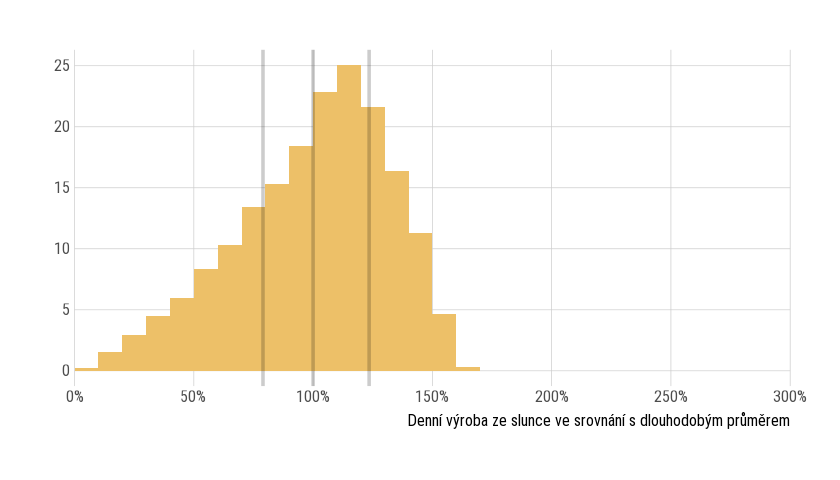

In [218]:
options(repr.plot.height = 4, repr.plot.width = 7)

df_cz_solar_summer |>
  ggplot(aes(SolarRelative, after_stat(count) / num_years)) +
  geom_histogram(
    fill = scales::col_lighter(scales::col_saturate(colour_solar, -10), 10),
    boundary = 0,
    binwidth = .1
  ) +
  geom_vline(xintercept = 1, linewidth = 1, alpha = .2) +
  geom_vline(
    aes(xintercept = q),
    linewidth = 1,
    alpha = .2,
    data = ~ reframe(.x, q = quantile(SolarRelative, c(.25, .75)))
  ) +
  scale_x_continuous(
    "Denní výroba ze slunce ve srovnání s dlouhodobým průměrem",
    labels = scales::label_percent(),
    limits = c(0, 3),
    breaks = seq(0, 3, .5),
    expand = expansion()
  ) +
  theme(
    axis.title.y = element_blank()
  )


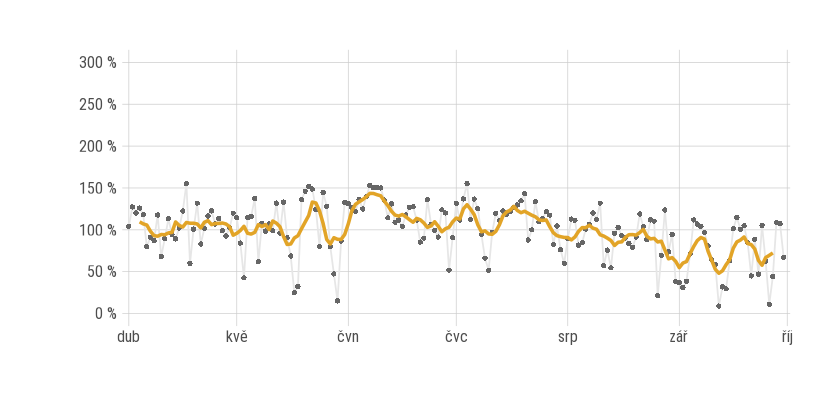

In [97]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

df_cz_solar_summer |>
  filter(Year == 2014) |>
  ggplot(aes(Date, SolarRelative)) +
  geom_line(colour = "#e6e6e6") +
  geom_point(colour = "#666666", stroke = 0) +
  geom_line(
    colour = "#e2a427",
    data = ~ rolling_means(.x, SolarRelative, k = 7),
    linewidth = 1
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3),
    breaks = seq(0, 3, .5)
  )


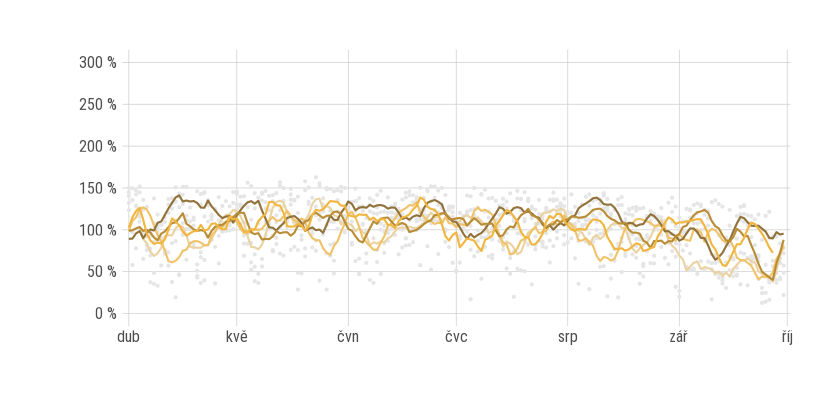

In [98]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

solar_years <- 2001:2005

df_cz_solar_summer |>
  mutate(Date = update(Date, year = 2008)) |>
  filter(Year %in% solar_years) |>
  ggplot(aes(Date, SolarRelative)) +
  geom_point(colour = "grey90", size = .5) +
  geom_line(
    aes(group = Year, colour = factor(Year)),
    data = ~ rolling_means(.x, SolarRelative, k = 7),
    linewidth = .6
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3),
    breaks = seq(0, 3, .5)
  ) +
  scale_colour_manual(
    values = colours_solar5,
    guide = "none"
  )


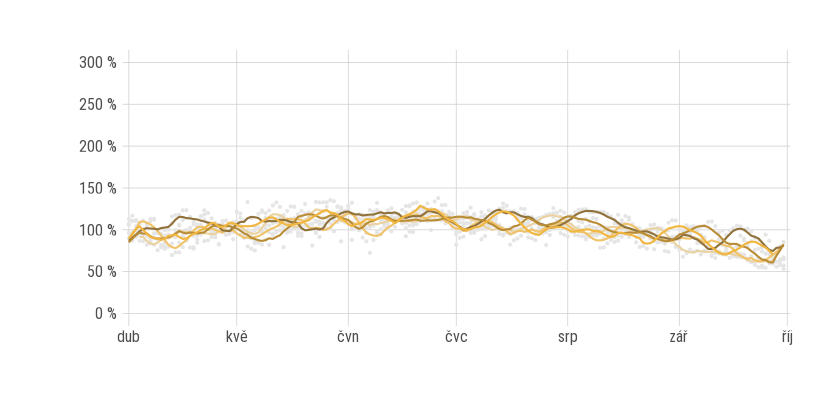

In [99]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

df_europe_daily_solar |>
  filter(between(Month, 4, 9)) |>
  mutate(
    SolarRelative = SolarCf / mean(SolarCf)
  ) |>
  mutate(Date = update(Date, year = 2008)) |>
  filter(Year %in% solar_years) |>
  ggplot(aes(Date, SolarRelative)) +
  geom_point(colour = "grey90", size = .5) +
  geom_line(
    aes(group = Year, colour = factor(Year)),
    data = ~ rolling_means(.x, SolarRelative, k = 7),
    linewidth = .6
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3),
    breaks = seq(0, 3, .5)
  ) +
  scale_colour_manual(
    values = colours_solar5,
    guide = "none"
  )


## Vítr


In [ ]:
df_cz_wind_winter <- df_cz_daily_wind |>
  filter((Month <= 3) | (Month >= 10)) |>
  mutate(
    WindRelative = WindCf / mean(WindCf),
    # Anchor to the year of the January in the interval.
    Year = if_else(Month < 6, Year, Year + 1)
  )


In [221]:
low_threshold <- .25

df_low_wind_intervals <- df_cz_wind_winter |>
  mutate(Below50Pct = WindRelative < low_threshold) |>
  filter(Below50Pct) |>
  group_by(Year) |>
  mutate(
    DateDiff = c(1, diff(Date)),
    Group = cumsum(DateDiff > 1)
  ) |>
  group_by(Group, .add = TRUE) |>
  summarise(
    StartDate = min(Date),
    NumDays = n(),
    .groups = "drop"
  )

df_low_wind_intervals |>
  count(NumDays, name = "Occurrences") |>
  mutate(
    Proportion = Occurrences / sum(Occurrences),
    CumOccurrs = rev(cumsum(rev(Occurrences * NumDays))),
    AvgCumOccurrs = CumOccurrs / num_years
  ) |>
  mutate(Proportion = signif(100 * Proportion, 3))


NumDays,Occurrences,Proportion,CumOccurrs,AvgCumOccurrs
<int>,<int>,<dbl>,<int>,<dbl>
1,337,61.400,912,24.0000000
2,125,22.800,575,15.1315789
3,46,8.380,325,8.5526316
4,27,4.920,187,4.9210526
5,8,1.460,79,2.0789474
6,3,0.546,39,1.0263158
7,3,0.546,21,0.5526316


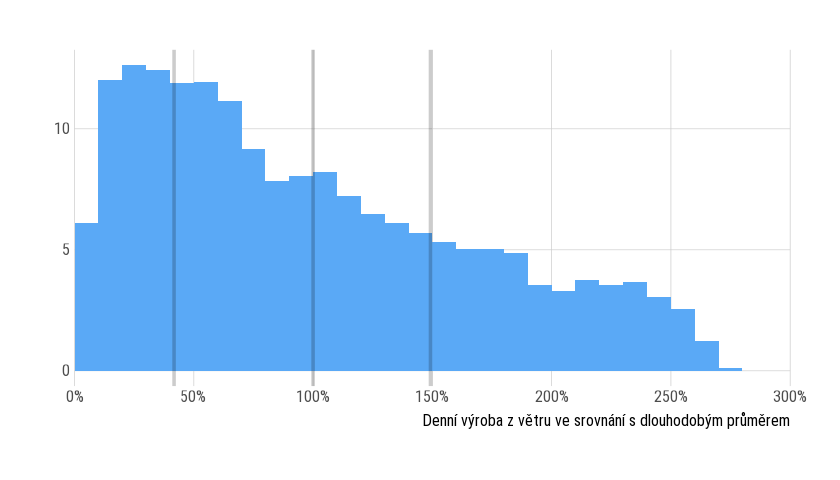

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 7)

df_cz_wind_winter |>
  ggplot(aes(WindRelative, after_stat(count) / num_years)) +
  geom_histogram(
    fill = scales::col_lighter(scales::col_saturate(colour_wind, -10), 10),
    boundary = 0,
    binwidth = .1
  ) +
  geom_vline(xintercept = 1, linewidth = 1, alpha = .2) +
  geom_vline(
    aes(xintercept = q),
    linewidth = 1,
    alpha = .2,
    data = ~ reframe(.x, q = quantile(WindRelative, c(.25, .75)))
  ) +
  scale_x_continuous(
    "Denní výroba z větru ve srovnání s dlouhodobým průměrem",
    labels = scales::label_percent(),
    breaks = seq(0, 3, .5),
    limits = c(0, 3),
    expand = expansion()
  ) +
  theme(
    axis.title.y = element_blank()
  )


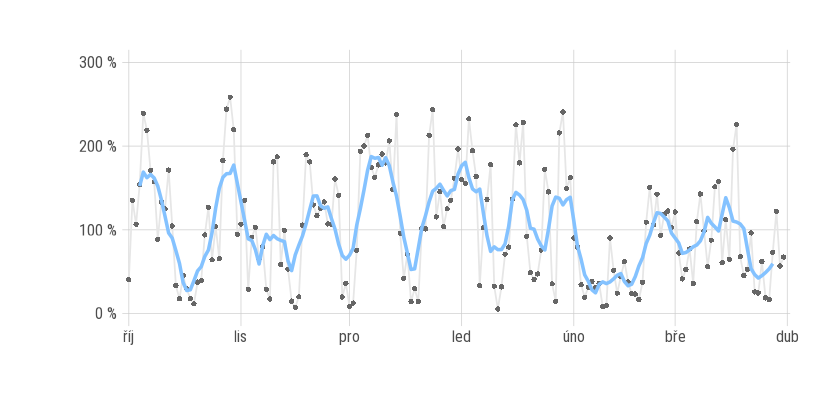

In [105]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

df_cz_wind_winter |>
  filter(Year == 2018) |>
  ggplot(aes(Date, WindRelative)) +
  geom_line(colour = "#e6e6e6") +
  geom_point(colour = "#666666", stroke = 0) +
  geom_line(
    colour = scales::col_lighter(colour_wind, 20),
    data = ~ rolling_means(.x, WindRelative, k = 7),
    linewidth = 1
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3)
  )


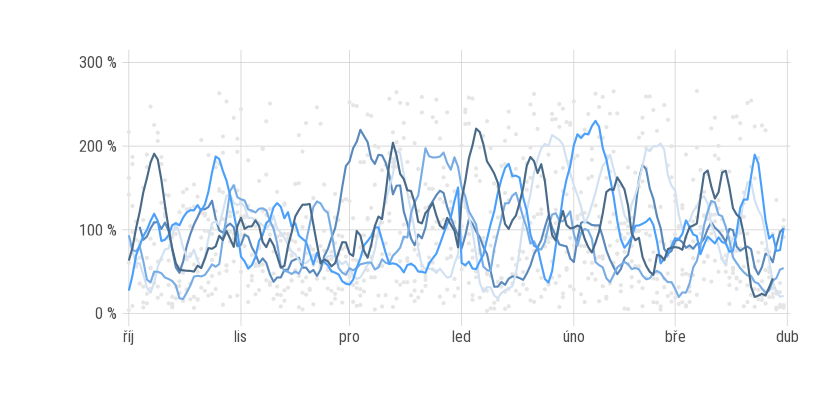

In [106]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

wind_years <- 2001:2005

df_cz_wind_winter |>
  mutate(
    Date = update(Date, year = if_else(Month < 6, 2009, 2008)),
    Year = if_else(Month < 6, Year, Year + 1)
  ) |>
  filter(Year %in% wind_years) |>
  ggplot(aes(Date, WindRelative)) +
  geom_point(colour = "grey90", size = .5) +
  geom_line(
    aes(group = Year, colour = factor(Year)),
    data = ~ rolling_means(.x, WindRelative, k = 7),
    linewidth = .6
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3)
  ) +
  scale_colour_manual(
    values = colours_wind5,
    guide = "none"
  )


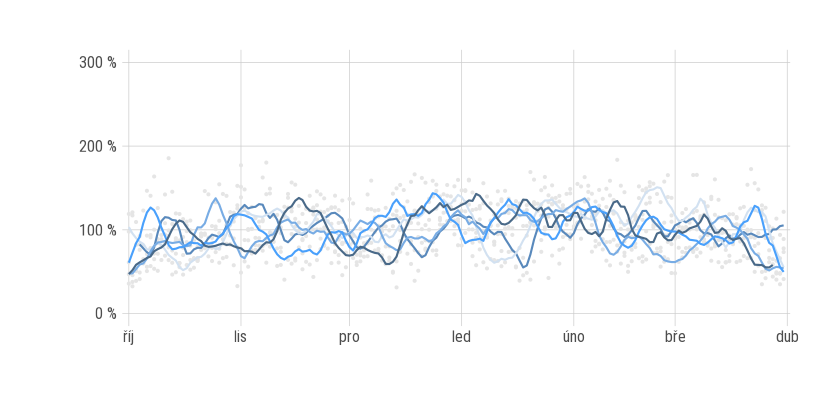

In [ ]:
options(repr.plot.height = 3.5, repr.plot.width = 7)

df_europe_daily_wind |>
  filter((Month <= 3) | (Month >= 10)) |>
  mutate(
    Date = update(Date, year = if_else(Month < 6, 2009, 2008)),
    Year = if_else(Month < 6, Year, Year + 1)
  ) |>
  mutate(
    WindRelative = WindCf / mean(WindCf)
  ) |>
  filter(Year %in% wind_years) |>
  ggplot(aes(Date, WindRelative)) +
  geom_point(colour = "grey90", size = .5) +
  geom_line(
    aes(group = Year, colour = factor(Year)),
    data = ~ rolling_means(.x, WindRelative, k = 7),
    linewidth = .6
  ) +
  scale_x_date(
    "",
    labels = scales::label_date("%b", locale = "cs_CZ"),
    date_breaks = "1 month",
    expand = expansion(mult = .01)
  ) +
  scale_y_continuous(
    "",
    labels = scales::label_percent(suffix = " %"),
    limits = c(0, 3)
  ) +
  scale_colour_manual(
    values = colours_wind5,
    guide = "none"
  )
